In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from statsmodels.distributions.empirical_distribution import ECDF 
import xarray as xr
import matplotlib.pyplot as plt

import time

from renewable_data_load import *

from threshold_tools import *

# Configure dask for parallel execution
import dask
dask.config.set(scheduler='threads', num_workers=10)  # Adjust num_workers to your CPU cores

/Users/work/miniconda3/envs/renewables-analysis/lib/python3.12/site-packages/intake_esm/__init__.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


In [2]:
resource = "pv"
module = "utility"
domain = "d02"
variable = "cf"
frequency = "day"
simulation = "taiesm1"
reference_gwl = 0.8
future_gwl = 2.0

window_size = 60

In [3]:
# Get bounds for reference GWL period
WRF_sim_name = sim_name_dict[simulation]
model = WRF_sim_name.split("_")[1]
ensemble_member = WRF_sim_name.split("_")[2]
ref_start_year, ref_end_year = get_gwl_crossing_period(model, ensemble_member, reference_gwl)
fut_start_year, fut_end_year = get_gwl_crossing_period(model, ensemble_member, future_gwl)

## Load the renewables data and associated drought threshold file

In [4]:
threshold_file = f"../data/thresholds/{resource}_{module}_{domain}_{variable}_{simulation}_gwlref{reference_gwl}_10th_pctile.nc"
drought_threshold_ds = xr.open_dataset(threshold_file)
ren_ds = get_ren_data_concat(resource, module, domain, variable, frequency, simulation)
ren_ds = ren_ds.convert_calendar("noleap")

### Reshape the renewables data based on day of year

In [5]:
# reshape array
ds_doy = ren_ds.copy(deep=True)
ds_doy['dayofyear'] = ds_doy.time.dt.dayofyear
ds_doy['year'] = ds_doy.time.dt.year
ds_doy = ds_doy.assign_coords(
    {"dayofyear":ds_doy.time.dt.dayofyear,
    "year":ds_doy.time.dt.year}
)
# reshape time dimension
ds_doy = ds_doy.drop_vars("time").set_index(time=['dayofyear','year']).unstack()

display(ds_doy)

<xarray.DataArray 'cf' (y: 320, x: 250, dayofyear: 365, year: 118)> Size: 28GB
dask.array<reshape, shape=(320, 250, 365, 118), dtype=float64, chunksize=(87, 42, 45, 118), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear          (dayofyear) int64 3kB 1 2 3 4 5 6 ... 361 362 363 364 365
  * year               (year) int64 944B 1981 1982 1983 1984 ... 2096 2097 2098
  * x                  (x) float64 2kB -4.638e+06 -4.629e+06 ... -2.397e+06
  * y                  (y) float64 3kB -2.441e+05 -2.351e+05 ... 2.627e+06
    Lambert_Conformal  int32 4B 1
    landmask           (y, x) float32 320kB 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
    lat                (y, x) float32 320kB 23.35 23.39 23.43 ... 56.42 56.46
    lon                (y, x) float32 320kB -116.5 -116.4 ... -111.6 -111.5
Attributes:
    data_type:             Gridded
    extended_description:  Ratio of power generated to panel nameplate capacity.
    frequency:             day
    grid_mapping:          Lambert_Conformal
    long_name:             capacity factor
    units:                 1

### Subtract the threshold to get "drought" metric

In [6]:
drought_ds = (ds_doy - drought_threshold_ds.reference_gen).load()

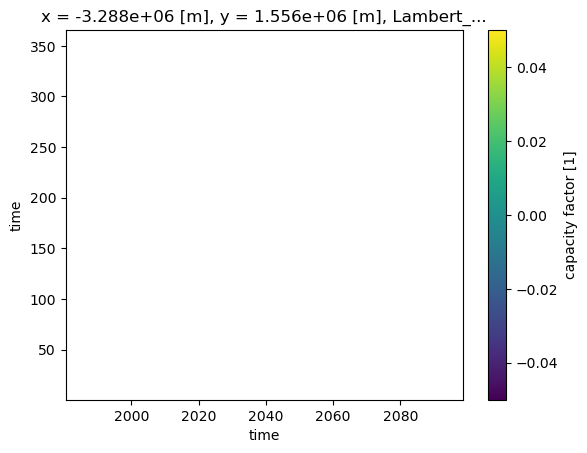

In [7]:
ds_doy.isel(x=150,y=200).plot(x='year',y='dayofyear', cmap='viridis')

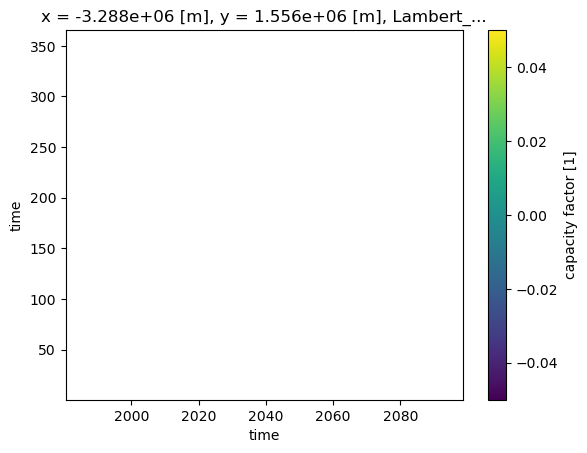

In [8]:
drought_ds.isel(x=150,y=200).plot(x='year',y='dayofyear', cmap='viridis')

In [9]:
# reshape back into daily timeseries
drought_ds = drought_ds.stack(time=['year','dayofyear'])
drought_ds = drought_ds.reset_index("time").assign_coords(time=ren_ds.time)


### Use threshold tools to find drought events

In [10]:
# make sure everything is loaded into memory
drought_ds = drought_ds.load()

In [11]:
# Divide into reference and future periods based on GWLs
drought_ds_reference = drought_ds.sel(time=slice(f"{ref_start_year}", f"{ref_end_year}"))
drought_ds_future = drought_ds.sel(time=slice(f"{fut_start_year}", f"{fut_end_year}"))

## Catalog Individual Drought Events

Create a dataset that tracks each individual drought event with its characteristics.

In [ ]:
def compute_event_stats_auto(data_values, is_drought_mask):
    """
    Compute statistics for all events at a single location.
    Returns lists that will be concatenated later.
    
    Parameters
    ----------
    data_values : np.ndarray
        1D array of drought values over time
    is_drought_mask : np.ndarray
        1D boolean array indicating drought days
    
    Returns
    -------
    tuple of lists
        (durations, intensities, magnitudes, start_indices) for all events at this location
    """
    from scipy import ndimage
    
    # Convert boolean to int for labeling
    drought_binary = np.where(is_drought_mask, 1, 0)
    
    # Label consecutive drought periods
    labeled_array, num_events = ndimage.label(drought_binary)
    
    # Lists to store results
    durations = []
    intensities = []
    magnitudes = []
    start_indices = []
    
    # Compute stats for each event
    for event_id in range(1, num_events + 1):
        event_mask = (labeled_array == event_id)
        event_data = data_values[event_mask]

        durations.append(np.sum(event_mask))
        intensities.append(np.min(event_data))
        magnitudes.append(np.sum(event_data))
        start_indices.append(np.argmax(event_mask))
    
    return durations, intensities, magnitudes, start_indices


def catalog_drought_events_ufunc(drought_ds, threshold_value=0):
    """
    Vectorized version using apply_ufunc with automatic event counting.
    
    Uses apply_ufunc to process all locations in parallel, then concatenates
    results without requiring pre-specification of max_events.
    
    Parameters
    ----------
    drought_ds : xr.DataArray
        Time series of drought metric values (dimensions: time, y, x)
    threshold_value : float
        Threshold below which values are considered drought (default: 0)
    
    Returns
    -------
    xr.Dataset
        Dataset with dimensions (y, x, event_id) containing event statistics
    """
    import xarray as xr
    import numpy as np
    
    # Identify drought conditions
    is_drought = (drought_ds < threshold_value).where(drought_ds.notnull())
    
    # Convert to boolean (fill NaN with False for processing)
    is_drought_bool = is_drought.fillna(False).astype(bool)
    
    # Use apply_ufunc to process all locations
    # This returns object arrays containing lists
    result = xr.apply_ufunc(
        compute_event_stats_auto,
        drought_ds,
        is_drought_bool,
        input_core_dims=[['time'], ['time']],
        output_core_dims=[[], [], [], []],  # Each returns a list (scalar from xarray's perspective)
        vectorize=True,
        dask='parallelized',
        output_dtypes=[object, object, object, object]
    )
    
    durations_obj, intensities_obj, magnitudes_obj, start_indices_obj = result
    
    # Now convert the object arrays of lists into a proper dataset
    all_events = []
    
    for y_idx in range(drought_ds.sizes['y']):
        for x_idx in range(drought_ds.sizes['x']):
            y_val = drought_ds.y.values[y_idx]
            x_val = drought_ds.x.values[x_idx]
            
            # Get the lists for this location
            durs = durations_obj.values[y_idx, x_idx]
            intens = intensities_obj.values[y_idx, x_idx]
            mags = magnitudes_obj.values[y_idx, x_idx]
            starts = start_indices_obj.values[y_idx, x_idx]
            
            # Add each event from this location
            for i, (dur, inten, mag, start) in enumerate(zip(durs, intens, mags, starts), 1):
                all_events.append({
                    'y': y_val,
                    'x': x_val,
                    'event_id': i,
                    'drought_duration': dur,
                    'max_intensity': inten,
                    'magnitude': mag,
                    'start_time': drought_ds.time.values[int(start)]
                })
    
    # Convert to DataFrame then to xarray
    if len(all_events) == 0:
        print("No drought events found!")
        return None
    
    df = pd.DataFrame(all_events)
    
    # Explicitly set dtypes to prevent datetime inference
    df['drought_duration'] = df['drought_duration'].astype(np.int32)
    df['max_intensity'] = df['max_intensity'].astype(np.float32)
    df['magnitude'] = df['magnitude'].astype(np.float32)
    
    df = df.set_index(['y', 'x', 'event_id'])
    event_ds = df.to_xarray()
    
    # Add metadata
    event_ds['drought_duration'].attrs['units'] = 'days'
    event_ds['drought_duration'].attrs['long_name'] = 'Drought event duration'
    
    event_ds['max_intensity'].attrs['units'] = drought_ds.units if hasattr(drought_ds, 'units') else ''
    event_ds['max_intensity'].attrs['long_name'] = 'Maximum drought intensity (most negative value)'
    
    event_ds['magnitude'].attrs['units'] = drought_ds.units if hasattr(drought_ds, 'units') else ''
    event_ds['magnitude'].attrs['long_name'] = 'Drought magnitude (cumulative deficit)'
    
    event_ds.attrs['threshold_value'] = threshold_value
    event_ds.attrs['description'] = 'Catalog of individual drought events (apply_ufunc with automatic event counting)'
    
    return event_ds

### Test apply_ufunc version

In [13]:

start_time = time.time()

event_catalog_ref = catalog_drought_events_ufunc(drought_ds_reference, threshold_value=0)

elapsed = time.time() - start_time
print(f"apply_ufunc version completed in {elapsed:.2f} seconds")
print(f"\nFound {event_catalog_ref.sizes['event_id']} total events")

display(event_catalog_ref)

apply_ufunc version completed in 4963.04 seconds

Found 908 total events


<xarray.Dataset> Size: 2GB
Dimensions:           (y: 320, x: 210, event_id: 908)
Coordinates:
  * y                 (y) float64 3kB -2.441e+05 -2.351e+05 ... 2.627e+06
  * x                 (x) float64 2kB -4.44e+06 -4.431e+06 ... -2.397e+06
  * event_id          (event_id) int64 7kB 1 2 3 4 5 6 ... 904 905 906 907 908
Data variables:
    drought_duration  (y, x, event_id) float64 488MB nan nan nan ... nan nan nan
    max_intensity     (y, x, event_id) float64 488MB nan nan nan ... nan nan nan
    magnitude         (y, x, event_id) float64 488MB nan nan nan ... nan nan nan
    start_time        (y, x, event_id) object 488MB nan nan nan ... nan nan nan
Attributes:
    threshold_value:  0
    description:      Catalog of individual drought events (apply_ufunc with ...

In [14]:

start_time = time.time()

event_catalog_fut = catalog_drought_events_ufunc(drought_ds_future, threshold_value=0)

elapsed = time.time() - start_time
print(f"apply_ufunc version completed in {elapsed:.2f} seconds")
print(f"\nFound {event_catalog_fut.sizes['event_id']} total events")

display(event_catalog_fut)

apply_ufunc version completed in 1110.68 seconds

Found 1010 total events


<xarray.Dataset> Size: 2GB
Dimensions:           (y: 320, x: 210, event_id: 1010)
Coordinates:
  * y                 (y) float64 3kB -2.441e+05 -2.351e+05 ... 2.627e+06
  * x                 (x) float64 2kB -4.44e+06 -4.431e+06 ... -2.397e+06
  * event_id          (event_id) int64 8kB 1 2 3 4 5 ... 1007 1008 1009 1010
Data variables:
    drought_duration  (y, x, event_id) float64 543MB nan nan nan ... nan nan nan
    max_intensity     (y, x, event_id) float64 543MB nan nan nan ... nan nan nan
    magnitude         (y, x, event_id) float64 543MB nan nan nan ... nan nan nan
    start_time        (y, x, event_id) object 543MB nan nan nan ... nan nan nan
Attributes:
    threshold_value:  0
    description:      Catalog of individual drought events (apply_ufunc with ...

In [15]:
event_catalog_ref.drop_vars('start_time').to_netcdf(f"../data/drought_events/{resource}_{module}_{domain}_{variable}_{simulation}_gwlref{reference_gwl}_event_catalog.nc")

In [16]:
event_catalog_fut.drop('start_time').to_netcdf(f"../data/drought_events/{resource}_{module}_{domain}_{variable}_{simulation}_gwlfut{future_gwl}_event_catalog.nc")

/var/folders/1w/yd54lcgx163cw02f2gzwh9880000gp/T/ipykernel_50561/2918510142.py:1: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  event_catalog_fut.drop('start_time').to_netcdf(f"../data/drought_events/{resource}_{module}_{domain}_{variable}_{simulation}_gwlfut{future_gwl}_event_catalog.nc")


In [17]:
# add new data variable "count" of drought events per location
event_counts = event_catalog_v3.drought_duration.count(dim='event_id')

NameError: name 'event_catalog_v3' is not defined

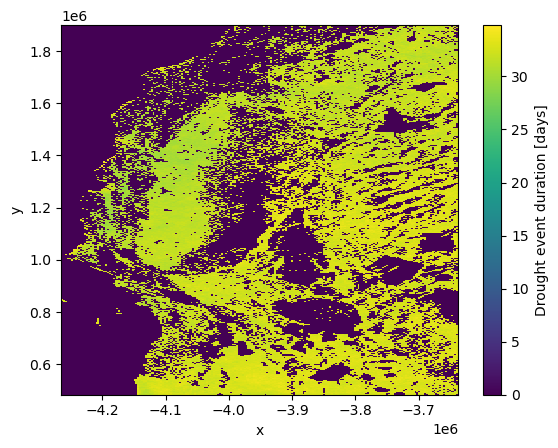

In [ ]:
(event_catalog_v3.drought_duration.sum('event_id')/30).plot()

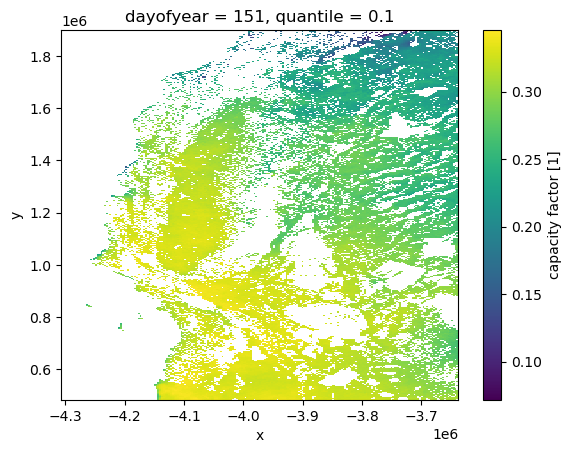

In [ ]:
drought_threshold_ds.isel(dayofyear=150).reference_gen.plot()

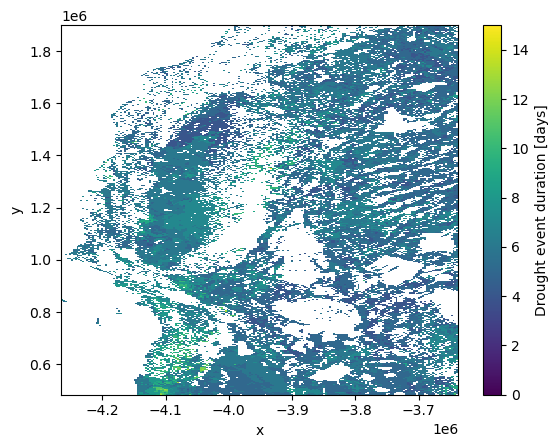

In [ ]:
(event_catalog_v3.drought_duration.max('event_id')).plot(vmin=0, vmax=15)

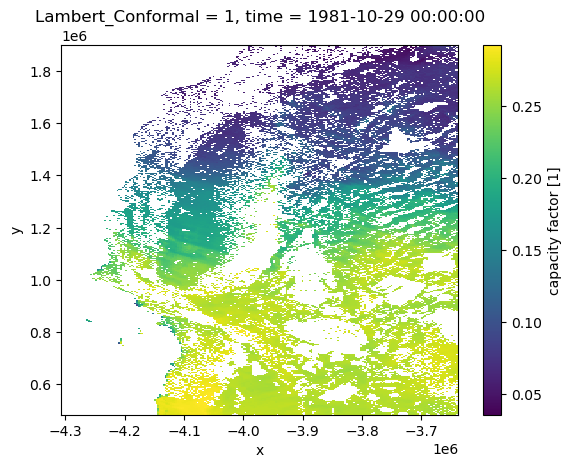

In [ ]:
ren_ds.isel(time=301).plot()